In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings

In [2]:
# Load S&P 500 prices
sp500_prices = pd \
    .read_csv("../data/raw/tessa_sp500_prices.csv") \
    .drop(columns=['GEV', 'SOLV', 'SW']) \
    .iloc[: , 1:] \
    .set_index("date", inplace=False)
    
# Load NCI prices
nci_prices = pd \
    .read_csv("../data/raw/tessa_nci_prices.csv") \
    .iloc[: , 1:] \
    .set_index("date", inplace=False)

# Left join on S&P
data = pd.merge(sp500_prices, nci_prices, on="date", how="left")

data.head(3)

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,ZTS,ADA-USD,AVAX-USD,BTC-USD,ETH-USD,LINK-USD,LTC-USD,SOL-USD,UNI-USD,XRP-USD
date,,,,,,,,,,,,,,,,,,,,,
2024-01-03,130.256195,183.150375,153.355072,133.419998,106.816635,73.162132,332.573761,571.789978,185.003098,69.802177,...,190.462128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-04,130.097305,180.824356,154.310791,133.720001,108.240593,73.666107,331.756866,567.049988,182.173630,68.484978,...,191.557953,0.570567,38.737835,44179.921875,2269.038086,14.554019,66.491394,105.077538,0.000221,0.588226
2024-01-05,129.660324,180.098679,154.960678,135.979996,108.065041,73.038513,331.294312,564.599976,182.643570,67.587761,...,192.357605,0.541242,36.434849,44162.691406,2268.647217,14.065112,66.021149,99.978790,0.000221,0.576486


In [3]:
portfolio = pd.read_csv("../data/processed/starting_portfolio.csv")

In [4]:
data.index = pd.to_datetime(data.index)
data = data.asfreq('D')

For stationarity checks, I referred briefly to this paper: https://business.columbia.edu/sites/default/files-efs/pubfiles/3970/computing_efficient_frontiers.pdf section 8 

## Stationarity check on daily prices

In [3]:
def check_stationarity_price(data: pd.DataFrame) -> dict:
    """
    Perform Augmented Dickey-Fuller (ADF) test on all asset price series in the dataset.

    Parameters:
        data (pd.DataFrame): DataFrame where index is dates and columns are asset prices.

    Returns:
        data (pd.DataFrame): DataFrame with asset names and their stationarity status (1 = stationary, 0 = non-stationary).
    """
    results = {"Asset": [], "Stationary": []}

    for asset in data.columns:
        series = data[asset].dropna()
        result = adfuller(series)
        p_value = result[1]
        
        # Stationary if p-value < 0.05
        results["Asset"].append(asset)
        results["Stationary"].append(1 if p_value < 0.05 else 0)

    # Convert dictionary to DataFrame
    results_df = pd.DataFrame(results)

    return results_df


In [4]:
results_price = check_stationarity_price(data)
(results_price["Stationary"] == 0).sum()

488

In [5]:
def plot_daily_price(data: pd.DataFrame, asset_name: str):
    """
    Plot the daily price for a specific asset.

    Parameters:
        data (pd.DataFrame): DataFrame where index is dates and columns are asset prices.
        asset_name (str): The asset name (column) to plot returns for.
    """
    series_asset = data[asset_name].dropna()
    result_asset = adfuller(series_asset)

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(series_asset, label=f'Daily Price - {asset_name}')

    # Set title and labels
    ax.set_title(f'Daily Price of {asset_name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Daily Price')

    # Format x-axis to show months
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show every month
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as YYYY-MM

    ax.legend()
    ax.grid(True)

    plt.savefig(f"../figures/{asset_name}_prices.png", dpi=300)  

    plt.show()

    print(result_asset[1])


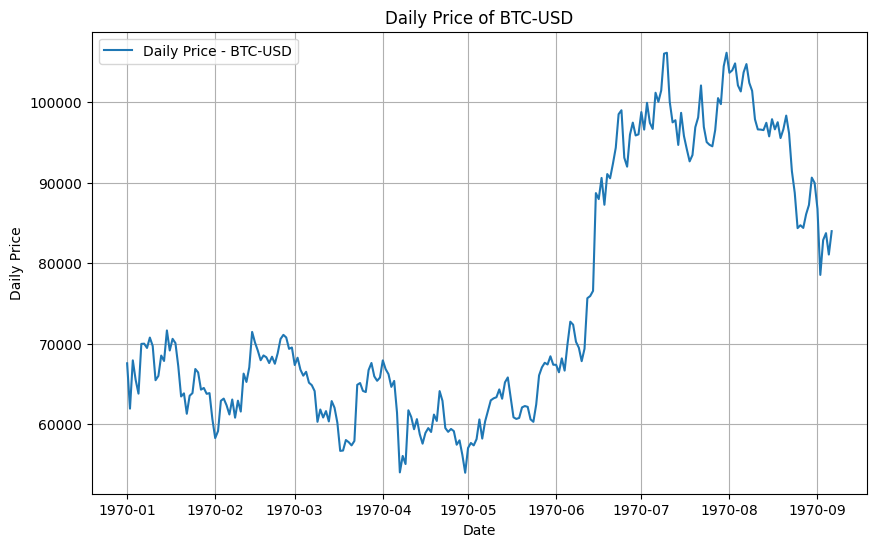

0.6624071195859544


In [6]:
plot_daily_price(data, 'BTC-USD')

## Stationarity check on daily returns 

In [5]:
def check_stationarity_all(data: pd.DataFrame) -> dict:
    """
    Perform Augmented Dickey-Fuller (ADF) test on daily returns of each asset 

    Parameters:
        data (pd.DataFrame): DataFrame where index is dates and columns are asset prices.

    Returns:
        data (pd.DataFrame): DataFrame with asset names and their stationarity status (1 = stationary, 0 = non-stationary).
    """
    results = {"Asset": [], "Stationary": []}
    daily_returns = data.pct_change()

    for asset in data.columns:
        series = daily_returns[asset].dropna()
        result = adfuller(series)
        p_value = result[1]
        
        # Stationary if p-value < 0.05
        results["Asset"].append(asset)
        results["Stationary"].append(1 if p_value < 0.05 else 0)

    # Convert dictionary to DataFrame
    results_df = pd.DataFrame(results)

    return results_df


In [6]:
# Run stationarity check for all assets
results = check_stationarity_all(data)
results

/var/folders/xx/r8ly5z917sl1cyljnn77j7z00000gn/T/ipykernel_73098/13107863.py:12: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = data.pct_change()


,Asset,Stationary
0,A,1
1,AAPL,1
2,ABBV,1
3,ABNB,1
4,ABT,1
...,...,...
502,LINK-USD,1
503,LTC-USD,1
504,SOL-USD,1
505,UNI-USD,1


In [7]:
(results["Stationary"] == 0).sum()

0

In [8]:
def plot_daily_returns(data: pd.DataFrame, asset_name: str):
    """
    Plot the daily returns for a specific asset.

    Parameters:
        data (pd.DataFrame): DataFrame where index is dates and columns are asset prices.
        asset_name (str): The asset name (column) to plot returns for.
    """
    # Calculate daily returns
    daily_returns = data.pct_change()

    series_asset = daily_returns[asset_name].dropna()
    result_asset = adfuller(series_asset)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(series_asset, label=f'Daily Return - {asset_name}')

    # Set title and labels
    ax.set_title(f'Daily Return of {asset_name}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Daily Return')

    # Format x-axis to show months
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show every month
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format as YYYY-MM

    ax.legend()
    ax.grid(True)

    plt.savefig(f"../figures/{asset_name}_returns.png", dpi=300)

    plt.show()

    print(result_asset[1])


/var/folders/xx/r8ly5z917sl1cyljnn77j7z00000gn/T/ipykernel_73098/1856252586.py:10: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = data.pct_change()


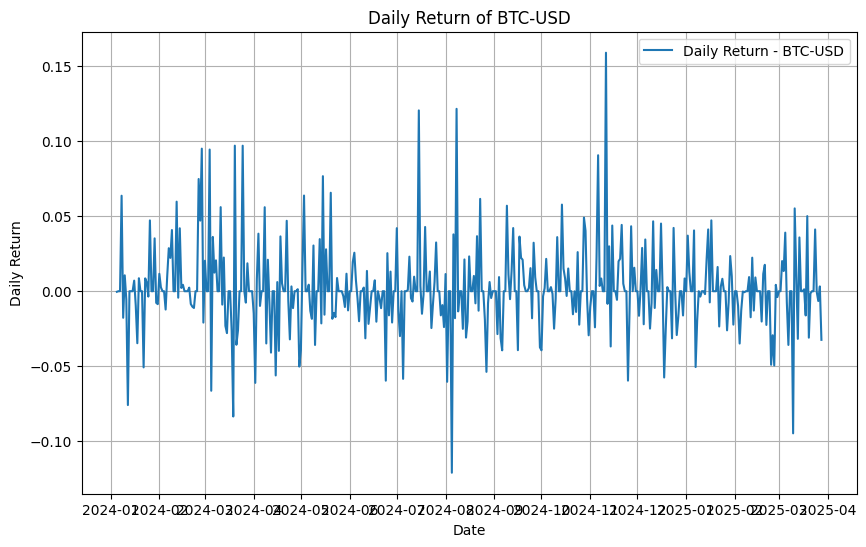

0.0


In [9]:
plot_daily_returns(data, 'BTC-USD')

## Time series plots / EDA

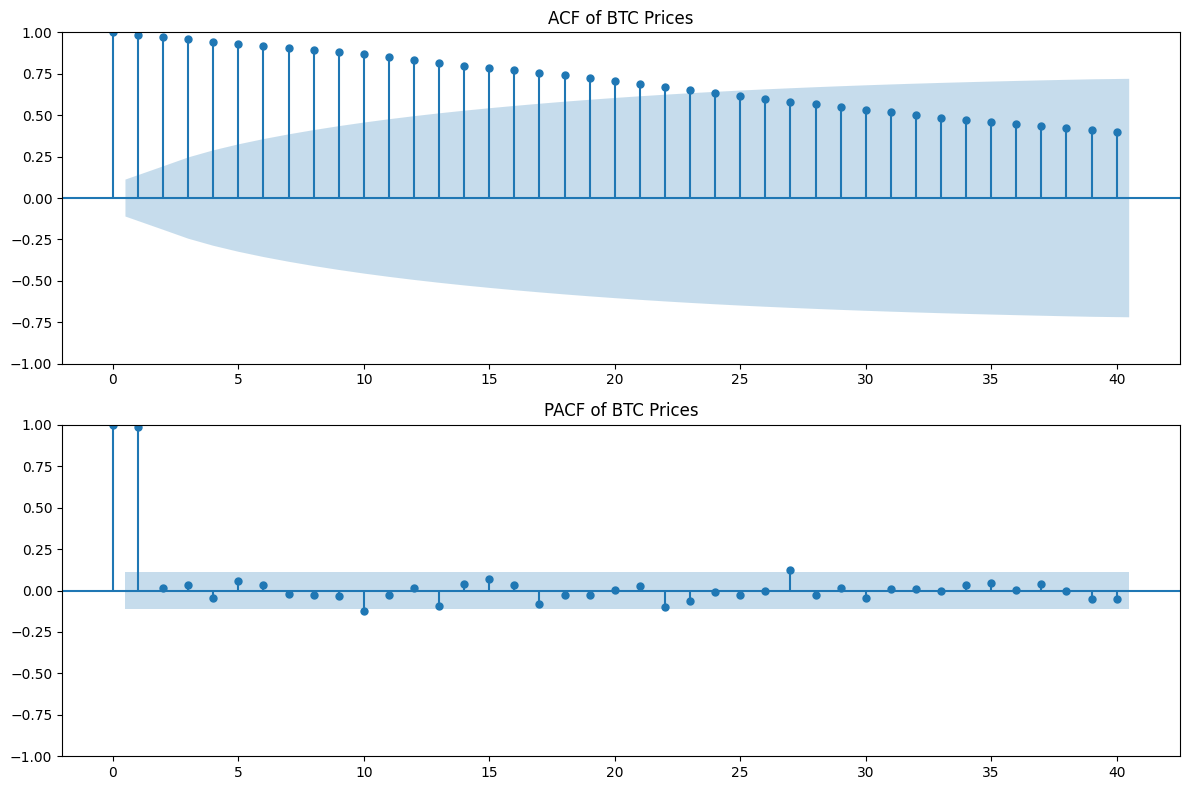

In [10]:
# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(data['BTC-USD'].dropna(), ax=ax[0], lags=40)
ax[0].set_title("ACF of BTC Prices")

plot_pacf(data['BTC-USD'].dropna(), ax=ax[1], lags=40)
ax[1].set_title("PACF of BTC Prices")

plt.tight_layout()
plt.savefig("../figures/btc_acf_pacf.png", dpi=300)  
plt.show()

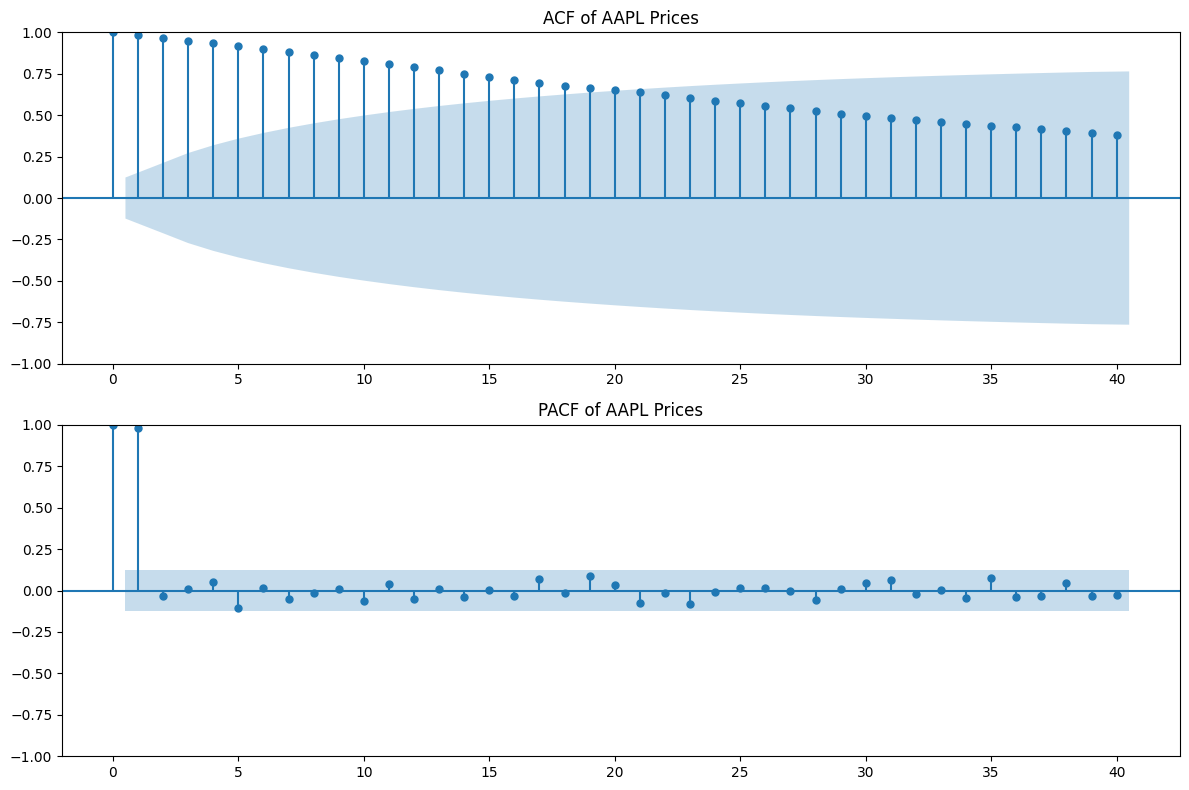

In [9]:
for asset in portfolio["asset"]:
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))

    plot_acf(data[asset].dropna(), ax=ax[0], lags=40)
    ax[0].set_title(f"ACF of {asset} Prices")

    plot_pacf(data[asset].dropna(), ax=ax[1], lags=40)
    ax[1].set_title(f"PACF of {asset} Prices")

    plt.tight_layout()
    plt.savefig(f"../figures/{asset}_acf_pacf.png", dpi=300)  

## AR Models

Modelling fitting using Box-Jenkins procedure

In [11]:
def fit_best_arma(series):
    """ Fit AR model and return the best based on BIC """
    best_bic = np.inf  
    best_order = None
    best_model = None
    
    for p in range(1, 4):  # Grid search
        try:
            model = ARIMA(series, order=(p, 0, 0)).fit()
            if model.bic < best_bic:
                best_bic = model.bic
                best_order = (p, 0, 0)
                best_model = model

        except:
            continue
    
    return best_model, best_order, best_bic

In [12]:
def analyze_assets(data, portfolio):
    """ Apply Box-Jenkins methodology to all assets """
    results = []
    
    for asset in portfolio["asset"]:
        print(f"analysing {asset}")
        series = data[asset].pct_change().dropna()
        best_model, best_order, best_bic = fit_best_arma(series)
        
        if best_model:
            coef = best_model.params.to_dict()  # Extract model coefficients
            results.append({
                "Asset": asset, 
                "Best Model": best_order, 
                "BIC": best_bic,
                **coef  # Expand coefficients into individual columns
            })
    
    return pd.DataFrame(results)

In [13]:
warnings.filterwarnings("ignore")

results_df = analyze_assets(data, portfolio)

analysing CZR
analysing INTC
analysing MHK
analysing BLDR
analysing URI
analysing ON
analysing NCLH
analysing ALB
analysing VST
analysing AVAX-USD
analysing SOL-USD
analysing LINK-USD


In [14]:
results_df

,Asset,Best Model,BIC,const,ar.L1,sigma2
0,CZR,"(1, 0, 0)",-2137.099847,-0.001004,-0.037306,0.000487
1,INTC,"(1, 0, 0)",-1898.767394,-0.001165,0.053588,0.000827
2,MHK,"(1, 0, 0)",-2237.419365,0.000454,0.064773,0.000389
3,BLDR,"(1, 0, 0)",-2146.278473,-0.000304,-0.037379,0.000477
4,URI,"(1, 0, 0)",-2284.821016,0.000504,-0.071571,0.000350
5,ON,"(1, 0, 0)",-2053.295520,-0.001143,-0.153363,0.000586
6,NCLH,"(1, 0, 0)",-2008.360786,0.000543,-0.014170,0.000648
7,ALB,"(1, 0, 0)",-1908.997544,-0.000997,-0.151407,0.000808
8,VST,"(1, 0, 0)",-1739.133780,0.003166,-0.093050,0.001179
9,AVAX-USD,"(1, 0, 0)",-1402.471749,-0.000203,0.003612,0.002473


In [15]:
results_df['Best Model'].value_counts() #(2,0,2) for all asset types 

Best Model
(1, 0, 0)    12
Name: count, dtype: int64

In [16]:
results_df.to_csv("../data/processed/ar_model.csv", index=False)

In [36]:
# want to do residual analysis? 